In [3]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [4]:
train = pd.read_csv('Dataset/Combined_Dataset_2022-18-02.csv')

In [43]:
train[train['manual_label'] == -1]

,sentences,manual_label
148,". indeed, two drugs (homoharringtonine and h...",-1.0
152,. the negative control compounds cinnamaldeh...,-1.0
162,". on the one hand, proteasome inhibition wit...",-1.0
163,". indeed, two drugs (homoharringtonine and h...",-1.0
173,. the half-maximal effective concentration (...,-1.0
...,...,...
767,Nicotine -Reaches brain within 15 s after puff...,-1.0
769,"Additionally, she developed kidney dysfunction...",-1.0
771,"Recently, some epidemiological studies indicat...",-1.0
773,"Till date, only dexamethasone and remdesivir h...",-1.0


In [6]:
#Let's get the dataset lenght
len(train)

790

In [7]:
#Is there any other different value than neutral, negative and positive?
train['manual_label'].unique()

array([ 0.,  1., -1.])

In [8]:
#How's distributed the dataset? Is it biased?
train.groupby('manual_label').nunique()

,disease,drug,sentences,distance,polarity,title
manual_label,,,,,,
-1.0,62,89,111,28,69,110
0.0,110,158,200,46,114,200
1.0,162,303,423,47,197,417


## Data cleaning

In [9]:
#Let's keep only the columns that we're going to use
train = train[['sentences','manual_label']]
train.head()

,sentences,manual_label
0,") population in thuringia (germany), (103) (...",0.0
1,christmas disease-national survey (biggs an...,0.0
2,christmas disease-national survey (biggs an...,0.0
3,christmas disease-national survey (biggs an...,0.0
4,5mg 00521183 dacarbazine iv pws 200mg/vi...,0.0


In [10]:
#Is there any null value?
train["sentences"].isnull().sum()

0

In [11]:
#Let's fill the only null value.
train["sentences"].fillna("No content", inplace = True)

In [12]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [13]:
temp = []
#Splitting pd.Series to list
data_to_list = train['sentences'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

[' ) population in thuringia (germany), (103) (2004) 121 chlamydophila abortus efficacy of different commercial and new inactivated vaccines against ovine enzootic abortion, (100) (2004) 65 recombinant major outer membrane protein (momp) of chlamydophila abortus, chlamydophila pecorum, and chlamydia suis as antigens to distinguish chlamydial species-specific antibodies in animal sera, (103) (2004) 85 molecular characterisation and ovine live vaccine 1b evaluation toward a chlamydophila abortus strain isolated from springbok antelope abortion, (103) (2004) 231 efficacy of live chlamydophila abortus vaccine 1b in protecting mice placentas and foetuses against strains of chlamydophila pecorum isolated from cases of abortion, (99) (2004) 295 recombinant major outer membrane protein (momp) of chlamydophila abortus, chlamydophila pecorum, and chlamydia suis as antigens to distinguish chlamydial species-specific antibodies in animal sera, (103) (2004) 85 chlamydophila psittaci molecular chara

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['population', 'in', 'thuringia', 'germany', 'chlamydophila', 'abortus', 'efficacy', 'of', 'different', 'commercial', 'and', 'new', 'inactivated', 'vaccines', 'against', 'ovine', 'enzootic', 'abortion', 'recombinant', 'major', 'outer', 'membrane', 'protein', 'momp', 'of', 'chlamydophila', 'abortus', 'chlamydophila', 'pecorum', 'and', 'chlamydia', 'suis', 'as', 'antigens', 'to', 'distinguish', 'chlamydial', 'species', 'specific', 'antibodies', 'in', 'animal', 'sera', 'molecular', 'and', 'ovine', 'live', 'vaccine', 'evaluation', 'toward', 'chlamydophila', 'abortus', 'strain', 'isolated', 'from', 'springbok', 'antelope', 'abortion', 'efficacy', 'of', 'live', 'chlamydophila', 'abortus', 'vaccine', 'in', 'protecting', 'mice', 'placentas', 'and', 'foetuses', 'against', 'strains', 'of', 'chlamydophila', 'pecorum', 'isolated', 'from', 'cases', 'of', 'abortion', 'recombinant', 'major', 'outer', 'membrane', 'protein', 'momp', 'of', 'chlamydophila', 'abortus', 'chlamydophila', 'pecorum', 'and', 

In [15]:
len(data_words)

790

In [16]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [17]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['population in thuringia germany chlamydophila abortus efficacy of different commercial and new inactivated vaccines against ovine enzootic abortion recombinant major outer membrane protein momp of chlamydophila abortus chlamydophila pecorum and chlamydia suis as antigens to distinguish chlamydial species specific antibodies in animal sera molecular and ovine live vaccine evaluation toward chlamydophila abortus strain isolated from springbok antelope abortion efficacy of live chlamydophila abortus vaccine in protecting mice placentas and foetuses against strains of chlamydophila pecorum isolated from cases of abortion recombinant major outer membrane protein momp of chlamydophila abortus chlamydophila pecorum and chlamydia suis as antigens to distinguish chlamydial species specific antibodies in animal sera chlamydophila psittaci molecular of chlamydial isolates from birds evaluation of the german cockroach blattella germanica as vector for verotoxigenic escherichia coli in confined s

In [18]:
data = np.array(data)

In [19]:
labels = np.array(train['manual_label'])
y = []
for i in range(len(labels)):
    if labels[i] == 0:
        y.append(0)
    if labels[i] == -1:
        y.append(1)
    if labels[i] == 1:
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [20]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [21]:
len(labels)

790

In [22]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 50000
max_len = 200

#tokenizer = Tokenizer(num_words=max_words)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
#sentences = pad_sequences(sequences, maxlen=max_len)
sentences = pad_sequences(sequences)
print(sentences)

[[   0    0    0 ...    5  401 2741]
 [   0    0    0 ...   46   23 2742]
 [   0    0    0 ...    5 1712  286]
 ...
 [   0    0    0 ...    1 1456  551]
 [   0    0    0 ... 2536  556 1311]
 [   0    0    0 ...   89    6   11]]


In [23]:
print(labels)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [24]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(sentences,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

592 198 592 198


In [80]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['manual_label']),
                                        y = train['manual_label']                                                    
                                    )
class_weights = dict(zip(np.unique(labels), class_weights)),
class_weights

({0.0: 2.330383480825959, 1.0: 1.266025641025641},)

In [81]:
train.manual_label.value_counts()
np.unique(train.manual_label)

array([-1.,  0.,  1.])

In [82]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1], class_weight={0: 1.266025641025641, 1: 0.5614783226723525, 2: 2.330383480825959})

Epoch 1/70
19/19 [==============================] - 6s 247ms/step - loss: 1.7382 - accuracy: 0.5895 - val_loss: 0.9291 - val_accuracy: 0.5859

Epoch 00001: val_accuracy improved from -inf to 0.58586, saving model to best_model1.hdf5
Epoch 2/70
19/19 [==============================] - 4s 234ms/step - loss: 1.1983 - accuracy: 0.5963 - val_loss: 0.9932 - val_accuracy: 0.5859

Epoch 00002: val_accuracy did not improve from 0.58586
Epoch 3/70
19/19 [==============================] - 4s 237ms/step - loss: 1.1487 - accuracy: 0.5963 - val_loss: 1.0301 - val_accuracy: 0.5859

Epoch 00003: val_accuracy did not improve from 0.58586
Epoch 4/70
19/19 [==============================] - 4s 234ms/step - loss: 1.1385 - accuracy: 0.5963 - val_loss: 0.9599 - val_accuracy: 0.5859

Epoch 00004: val_accuracy did not improve from 0.58586
Epoch 5/70
19/19 [==============================] - 4s 231ms/step - loss: 1.1044 - accuracy: 0.5963 - val_loss: 0.9566 - val_accuracy: 0.5859

Epoch 00005: val_accuracy did 

In [83]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=1328))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2], class_weight={0: 1.266025641025641, 1: 0.5614783226723525, 2: 2.330383480825959})

Epoch 1/70
19/19 [==============================] - 8s 311ms/step - loss: 1.4922 - accuracy: 0.5980 - val_loss: 1.0194 - val_accuracy: 0.5859

Epoch 00001: val_accuracy improved from -inf to 0.58586, saving model to best_model2.hdf5
Epoch 2/70
19/19 [==============================] - 5s 278ms/step - loss: 1.1566 - accuracy: 0.5963 - val_loss: 1.1100 - val_accuracy: 0.5859

Epoch 00002: val_accuracy did not improve from 0.58586
Epoch 3/70
19/19 [==============================] - 5s 277ms/step - loss: 1.1269 - accuracy: 0.5963 - val_loss: 0.9886 - val_accuracy: 0.5859

Epoch 00003: val_accuracy did not improve from 0.58586
Epoch 4/70
19/19 [==============================] - 5s 277ms/step - loss: 1.0492 - accuracy: 0.5963 - val_loss: 0.9573 - val_accuracy: 0.5859

Epoch 00004: val_accuracy did not improve from 0.58586
Epoch 5/70
19/19 [==============================] - 5s 273ms/step - loss: 0.9377 - accuracy: 0.5963 - val_loss: 0.9846 - val_accuracy: 0.5859

Epoch 00005: val_accuracy did 

In [84]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=1328))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3], class_weight={0: 1.266025641025641, 1: 0.5614783226723525, 2: 2.330383480825959})

Epoch 1/70
19/19 [==============================] - 1s 22ms/step - loss: 2.5240 - accuracy: 0.5912 - val_loss: 1.7868 - val_accuracy: 0.5859

Epoch 00001: val_accuracy improved from -inf to 0.58586, saving model to best_model3.hdf5
Epoch 2/70
19/19 [==============================] - 0s 16ms/step - loss: 1.9386 - accuracy: 0.5963 - val_loss: 1.6581 - val_accuracy: 0.5859

Epoch 00002: val_accuracy did not improve from 0.58586
Epoch 3/70
19/19 [==============================] - 0s 16ms/step - loss: 1.7511 - accuracy: 0.5963 - val_loss: 1.5076 - val_accuracy: 0.5859

Epoch 00003: val_accuracy did not improve from 0.58586
Epoch 4/70
19/19 [==============================] - 0s 16ms/step - loss: 1.6110 - accuracy: 0.5963 - val_loss: 1.4168 - val_accuracy: 0.5859

Epoch 00004: val_accuracy did not improve from 0.58586
Epoch 5/70
19/19 [==============================] - 0s 16ms/step - loss: 1.4973 - accuracy: 0.5963 - val_loss: 1.3263 - val_accuracy: 0.5859

Epoch 00005: val_accuracy did not i

In [26]:
#Let's load the best model obtained during training
best_model2 = keras.models.load_model("best_model2.hdf5")

In [27]:
test_loss, test_acc = best_model2.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

7/7 - 1s - loss: 0.9424 - accuracy: 0.6667
Model accuracy:  0.6666666865348816


In [28]:
predictions = best_model2.predict(X_test)

In [36]:
np.argmax(predictions, axis=1)

array([0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0,
       0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2,
       2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2])

In [32]:
y_test.argmax(axis=1)

array([1, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 2, 1, 2, 2,
       0, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0, 2, 1, 2,
       0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2,
       2, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1,
       2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2,
       2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2])

In [25]:
#Let's load the best model obtained during training
best_model1 = keras.models.load_model("best_model1.hdf5")

test_loss, test_acc = best_model1.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

2022-06-04 14:49:33.516126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


7/7 - 1s - loss: 1.9125 - accuracy: 0.6616
Model accuracy:  0.6616161465644836


In [89]:
predictions1 = best_model.predict(X_test)

In [90]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
matrix1 = confusion_matrix(y_test.argmax(axis=1), np.around(predictions1, decimals=0).argmax(axis=1))

In [91]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1)))

In [92]:
print(classification_report(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.52      0.49      0.50        61
           1       0.00      0.00      0.00        21
           2       0.71      0.86      0.78       116

    accuracy                           0.66       198
   macro avg       0.41      0.45      0.43       198
weighted avg       0.58      0.66      0.61       198



In [93]:
print(classification_report(y_test.argmax(axis=1), np.around(predictions1, decimals=0).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.44      0.49        61
           1       0.00      0.00      0.00        21
           2       0.69      0.88      0.77       116

    accuracy                           0.65       198
   macro avg       0.41      0.44      0.42       198
weighted avg       0.57      0.65      0.60       198



<AxesSubplot:>

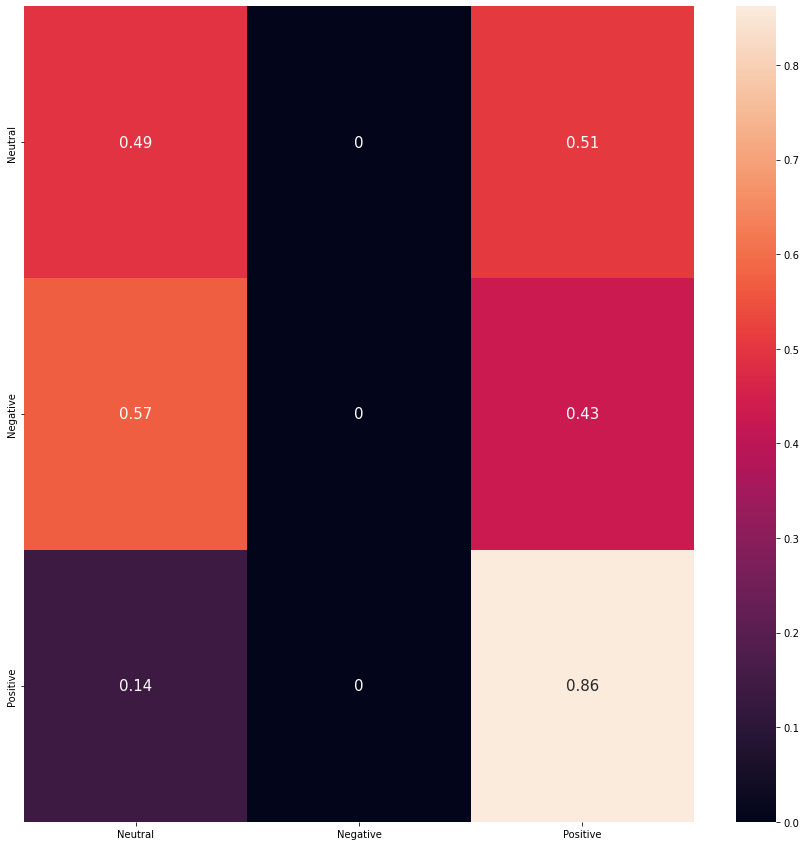

In [94]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [101]:
best_model3 = keras.models.load_model('best_model3.hdf5')

In [155]:
sequence = tokenizer.texts_to_sequences(['based on the above findings, a diagnosis of chronic invasive mucormycosis with recurrence was established, and treatment with sski and itraconazole was stopped.'])
test = pad_sequences(sequence)
print(sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]])
predict = best_model1.predict(test)
#print(np.around(predict[0][np.argmax(predict, axis=1)][0]*100, decimals=2))
np.around(predict[0][predict.argmax(axis=-1)][0]*100, decimals=2)

Negative


93.9

In [95]:
sentiment = ['Neutral','Negative','Positive']

In [154]:
sequence = tokenizer.texts_to_sequences(['auranofin is an orally bioavailable gold salt introduced in the 1980s as a disease-modifying treatment for rheumatoid arthritis.'])
test = pad_sequences(sequence)
sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [153]:
sequence = tokenizer.texts_to_sequences(['based on findings, it was considered that the treatment with clozapine and hydroxychloroquine caused neutropenia.'])
test = pad_sequences(sequence)
sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [98]:
sequence = tokenizer.texts_to_sequences(['based on the above findings, a diagnosis of chronic invasive mucormycosis with recurrence was established, and treatment with sski and itraconazole was stopped.'])
test = pad_sequences(sequence)
sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [99]:
sequence = tokenizer.texts_to_sequences(['Similarly, among 209 patients admitted with COVID-19 in Turkey, lower vertebral bone density, as assessed by computed tomography, was associated with increased mortality risk in multivariate analyses (27)'])
test = pad_sequences(sequence)
sentiment[np.around(best_model1.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [167]:
def classPredict(row):
    sentences = row['sentences']
    sequence = tokenizer.texts_to_sequences([sentences])
    test = pad_sequences(sequence)
    predict = best_model1.predict(test)
    return pd.Series((np.around(predict[0][predict.argmax(axis=-1)][0]*100, decimals=2), sentiment[np.around(predict, decimals=0).argmax(axis=1)[0]]))

In [114]:
productionDataset = pd.read_csv('Dataset/cleaned_dataset_with_labels.csv')

In [116]:
productionDataset = productionDataset[['disease', 'drug', 'sentences']]

In [183]:
productionDataset['class'].value_counts()

Positive    2145
Neutral      207
Negative     159
Name: class, dtype: int64

In [169]:
productionDataset[['confidence', 'class']] = productionDataset.apply(classPredict, axis=1)

In [184]:
productionDataset.to_csv('Results/result_on_dataset_05-03-2022.csv', index=False)

In [185]:
productionDataset

,disease,drug,sentences,confidence,class
0,COVID-19,Hydroxychloroquine,She was confirmed to be SARS-CoV2 positive and...,99.97,Positive
1,cancer,Teriflunomide,"Teriflunomide downregulation of MMP-9, epithel...",84.17,Neutral
2,hepatitis,Sofosbuvir,Sofosbuvir is an FDA-approved drug that is mai...,94.59,Positive
3,cardiomyopathy,Acetylcholine,CHRM2 encodes muscarinic acetylcholine recepto...,63.05,Neutral
4,cancer,Hydrogen,investigated the effects of Pd-Ni hydrogen sto...,99.99,Positive
...,...,...,...,...,...
2506,COVID-19,Ozone,Ozone therapy can be a better technique for th...,99.95,Positive
2507,cancer,NADH,"Overall, these findings suggest that, while pa...",99.95,Positive
2508,arthritis,Iguratimod,"Iguratimod is a new small molecular, anti-rheu...",96.08,Positive
2509,COVID-19,Ciclesonide,"Thus, ciclesonide is expected to have a dual e...",99.96,Positive
